# ALS Algorithm Implementation

## 1. Read in the data and preprocess 
We want to convert the ratings.csv file that is read in into R(n_users x n_movies) matrix. In the first cell we also import all the lubraries we need throughout the notebook

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#read in the data
data = pd.read_csv("../data/ml-latest-small/ratings.csv")

#get the necessary dimensions
n_users = data['userId'].nunique()
n_movies = data['movieId'].nunique()
movieIds = sorted(data.movieId.unique())

[ 5 20 16  6  4  1 10 11 12  8 21  3 14 22 18 17 23 19 15  2  9  7 13]


### For Temporal dynamics

We also need to bin the data into different bins for the temporal function. We split the data into 23 bins because that is the number of years the data spans

In [ ]:
#split the data into different bins for the temporal function. We split the data
#into 23 bins because that is the number of years the data spans
def get_bin(num):
    #subtracts 25 because they started collecting the data 25 years after january 1970
    return int((num)/(60*60*24*365)) - 25
data["bin"] = data["timestamp"].apply(get_bin)

#create initial R matrix
R_init = np.zeros((n_users, n_items))
bin_match = np.zeros((n_users, n_items)) 

#stored the bin number for each user movie pair
for row in data.itertuples():
    #print(row)
    R_init[row[1]-1, movieIds.index(row[2])] = row[3]
    bin_match[row[1]-1, movieIds.index(row[2])] = int(row[5]-1)

### Helper functions to extract R matrix from  any data, compute the RMSE and predict ratings

In [175]:
def get_error(R, R_hat):
    #only for the that had ratings in the training matrix
    mask = (R>0)
    R_hat[mask] = 0 #set the values we don't need predictions for to 0 
    return np.sqrt(((R - R_hat)**2).mean()) #return the RMSE

def predict(U, M, mu,b_i, b_u, bin_match ,B_i_bint):
    R = np.zeros((n_users, n_movies))
    #do we need to iterate over time as well
    for u in range(n_users):#iterate over users
        for i in range(n_movies):#iterate over movies
            bin_num = int(bin_match[u,i]) #get the bin number for user u and movie i
            R[u,i] = mu+b_u[u]+b_i[i]+B_i_bint[bin_num,i]+np.dot(U[u,:],M[i,:].T)
    return R

## 2. Train function for updating M and U matrices alternately 
The function also updates bi, bu and bi_bin(t) alternately

In [208]:
#alternate implementation from online resource
np.random.seed(1)
def train(Mat, bin_match, f, lambda_, n_iter):
    R = Mat[:]
    # Step 1 Initialize matrix M by assigning the average rating for that movie as the first row, and small random numbers for the remaining entries.
    M = np.random.rand(n_movies,f)
    M[:,0] = R.sum(0)/(R!=0).sum(0).astype(float)
    
    U = np.random.rand(n_users,f)#initialize U matrix
    
    mu = R.sum()/(R!=0).sum().astype(float)#average rating
    b_i = np.random.rand(n_movies)#initialize b_i = len(movies)
    b_u = np.random.rand(n_users) #initialize b_u = len(users)
    B_i_bint = np.random.rand(data['bin'].nunique(),n_movies)
    
    #function to minimize: sum(r_ui - ^r_ui) + lambda(b_i^2 + b_u^2+ |q|^2 + |p|^2 )
    for epoch in range(n_iter):
        #Step 2 Fix M, Solve U by minimizing the objective function
        for i in range(n_users):
            I_i = np.nonzero(R[i,:])[0] #set of movies that user i rated
            n_ui = len(I_i) #number of ratings user i has given 
            E = np.identity(f+1)
            idx = np.vstack([bin_match[i,I_i], I_i]).astype(int)
            r_u = R[i,I_i] - b_i[I_i] - mu #- B_i_bint[tuple(idx)]
            m = np.ones((n_movies,1))
            M_p = np.concatenate((m,M),1)
            M_Ii = M_p[I_i,:]
            u_prime = np.linalg.solve((np.dot(M_Ii.T,M_Ii)+(lambda_*E)), np.dot(r_u,M_Ii))
            b_u[i] = u_prime[0]
            U[i,:] = u_prime[1:]
           
        #Step 3 Fix U, solve M by minimizing the objective function similarly; 
        for j in range(n_movies):
            I_j = np.nonzero(R[:,j])[0] #set of users that rated movie j
            n_mj = len(I_j) #number of users that rated movie j
            matches = bin_match[I_j,j].astype(int) #the t for each user with movie j
            r_j = R[I_j,j] - b_u[I_j] - mu #- B_i_bint[matches,j]
            
            u = np.ones((n_users,1))
            U_p = np.concatenate((u,U),1)
            U_Ij = U_p[I_j,:]
            m_prime = np.linalg.solve((np.dot(U_Ij.T,U_Ij)+(lambda_*E)), np.dot(r_j,U_Ij))
            b_i[j] = m_prime[0]
            M[j,:] = m_prime[1:]
            
            #if the movie is not represented in the training data
            if(np.linalg.norm(m_prime)==0):
                b_i[j] = np.random.rand(1)
                M[j,:] = np.random.rand(f)
            
        for t in range(len(B_i_bint)):
            mask = bin_match == t
            for i in range(n_movies):
                r_it = R[:,i][mask[:,i]]- mu - b_u[mask[:,i]] - b_i[i]- np.dot(U[mask[:,i]], M[i,:])
                B_i_bint[t,i] = np.sum(r_it)/(len(r_it)+lambda_)                                                   
    
        R_hat = predict(U, M, mu,b_i, b_u, bin_match ,B_i_bint)
        error = get_error(R, R_hat)
        print("iteration: ", epoch, "; error: ", error)
    
    return U, M,mu, b_u, b_i, B_i_bint

## 3. Cross-validation function
This function just splits the data into different folds and then runs the train function and computes train and test errors for the different train-test splits we choose

In [209]:
def get_fold(data,K):
    fold_num = []
    i =0
    while i<len(data):
        for j in range(5):
            if(i<len(data)):
                fold_num.append(j)
            i+=1
    return fold_num

def cv(X, K, f, lambda_):
    df = X
    df['fold'] = get_fold(X,K)
    test_errors = []
    train_errors = []
    for k in range(K):
        print("fold: ", k)
        k_test = df[df.fold == k]
        k_train = df[df.fold != k]
        k_train_mat, k_train_bins = get_mat(k_train)
        k_test_mat, k_test_bins = get_mat(k_test)
        
        #get the parameters
        k_train_U, k_train_M, k_train_mu, k_train_b_u, k_train_b_i, k_train_B_i_bint = train(k_train_mat, k_train_bins, f, lambda_, 10)
        k_train_hat = predict(k_train_U, k_train_M, k_train_mu,k_train_b_i, k_train_b_u, k_train_bins ,k_train_B_i_bint)
        
        #get training error
        train_error = get_error(k_train_mat, k_train_hat)
        train_errors.append(train_error)
        
        #get the prediction
        k_test_hat = predict(k_train_U, k_train_M, k_train_mu,k_train_b_i, k_train_b_u, k_test_bins ,k_train_B_i_bint)
        error = get_error(k_test_mat, k_test_hat)
        test_errors.append(error)
        
    return train_errors, test_errors

### Tuning for optimal parameters using K-Fold cross validation. 
The results of the cross validation(the errors etc for each iteration) are stored in output folder in the csv files named params 1 - params 9 each corresponding to a pairing from f_s below and lambda_s

In [ ]:
#run the cross validation and test
"""
f_s = [2,4,10]
lambda_s= [0.1,1,5] 

#train for 10 iterarions each time
trains = []
tests = []
for f in f_s:
    train_avs = []
    test_avs = []
    for lambda_ in lambda_s:
        tr_errors, tst_errors = cv(data, 5, f, lambda_ )
        train_avs.append(np.mean(tr_errors))
        test_avs.append(np.mean(tst_errors))
    trains.append(train_avs)
    tests.append(test_avs)
"""
#commented out because the cv runs too long is the cell is run
               

## 4. Evaluation

### Visualize the results from the cross validation

Below we see the final train and test RMSE's for each set of parameter combinations that we were trying to observe in the cross validation step

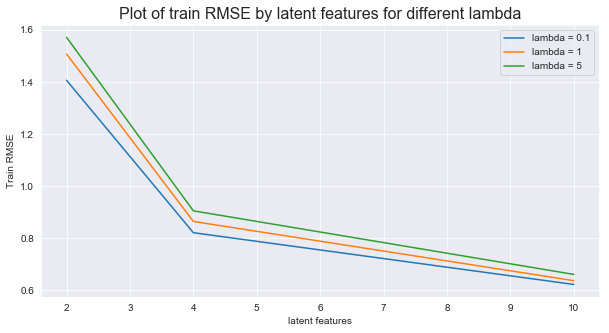

In [286]:
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
plt.plot(f_s,trains[0])
plt.plot(f_s,trains[1])
plt.plot(f_s,trains[2])

plt.legend(['lambda = 0.1', 'lambda = 1', 'lambda = 5'], loc='upper right')
plt.xlabel('latent features', fontsize=10)
plt.ylabel('Train RMSE', fontsize=10)
plt.title("Plot of train RMSE by latent features for different lambda", fontsize=16)
plt.savefig('../output/train_RMSE.png')
plt.show()

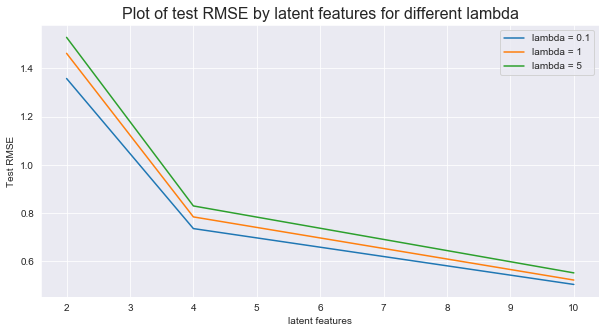

In [287]:
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
plt.plot(f_s,tests[0])
plt.plot(f_s,tests[1])
plt.plot(f_s,tests[2])

plt.legend(['lambda = 0.1', 'lambda = 1', 'lambda = 5'], loc='upper right')
plt.xlabel('latent features', fontsize=10)
plt.ylabel('Test RMSE', fontsize=10)
plt.title("Plot of test RMSE by latent features for different lambda", fontsize=16)
plt.savefig('../output/test_RMSE.png')
plt.show()

### Plots of how the train RMSE changes with each iteration for 5 folds for selected f lambda combinations
The goal of this is to see how the trend looks, i.e. is the RMSE reducing from iteration to iteration. What is the RMSE trend for different runs of cross validation for different parameter combinations

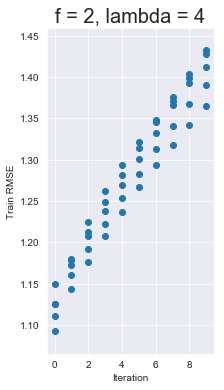

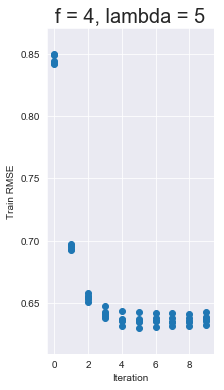

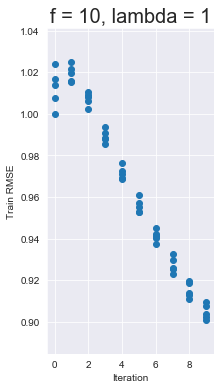

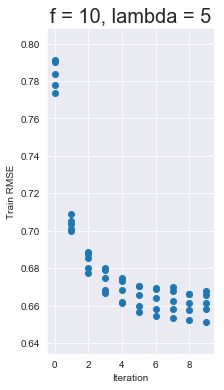

In [290]:
combo1 = pd.read_csv('../output/params1.csv', sep=',',header=None).values
combo6 = pd.read_csv('../output/params6.csv', sep=',',header=None).values
combo8 = pd.read_csv('../output/params8.csv', sep=',',header=None).values
combo9 = pd.read_csv('../output/params9.csv', sep=',',header=None).values

e = [combo1 ,combo6,combo8, combo9]
p_s = [(2,4),(4,5),(10,1),(10,5)]
for i in range(len(e)):
    plt.figure(figsize=(3,6))
    plt.scatter(e[i][:,0], e[i][:,1])
    plt.title("f = {}, lambda = {}".format(p_s[i][0],p_s[i][1]),fontsize=20)
    plt.xlabel("Iteration")
    plt.ylabel("Train RMSE")
    plt.savefig('../output/{}.png'.format(i))
    

## 5. Re-train using the optimal parameters obtained from the tuning step with cross validation 

Once we obtain the U, M and bias matrices needed by KNN postprocessing,write those into CSV files that are stored in the output folder of the repository.


In [230]:
#using the final train data 80%
df = pd.read_csv("../output/data_train.csv")[["userId","movieId","rating","timestamp","bin_num"]]

R, bins = get_mat(df)
U, M, mu, b_u, b_i, B_i_bint = train(R, bins,2, 5, 20)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


iteration:  0 ; error:  0.8661330198501733
iteration:  1 ; error:  0.6859166095955246
iteration:  2 ; error:  0.6363769409786096
iteration:  3 ; error:  0.6239577050205374
iteration:  4 ; error:  0.6213006289933475
iteration:  5 ; error:  0.6213341161473218
iteration:  6 ; error:  0.6221553686251834
iteration:  7 ; error:  0.6241984155873216
iteration:  8 ; error:  0.6261139561210961
iteration:  9 ; error:  0.6267379722235308
iteration:  10 ; error:  0.6266736916270217
iteration:  11 ; error:  0.6270278308401344
iteration:  12 ; error:  0.6280963063860351
iteration:  13 ; error:  0.6287950548246621
iteration:  14 ; error:  0.628075603724751
iteration:  15 ; error:  0.6278146989719049
iteration:  16 ; error:  0.6280232632574726
iteration:  17 ; error:  0.6273758738134373
iteration:  18 ; error:  0.6280593585253713
iteration:  19 ; error:  0.628062334767206


In [214]:
#pd.DataFrame(U.T).to_csv("../output/P_ALS.csv")
#pd.DataFrame(M.T).to_csv("../output/Q_ALS.csv")
pd.DataFrame(b_u).T.to_csv("../output/b_user_ALS.csv")
pd.DataFrame(b_i).T.to_csv("../output/b_item_ALS.csv")
#pd.DataFrame(B_i_bint).to_csv("../output/b_time_ALS.csv")